# Data Wrangling with Pandas

Now that we have been exposed to the basic functionality of Pandas, lets explore some more advanced features that will be useful when addressing more complex data management tasks.

As most statisticians/data analysts will admit, often the lion's share of the time spent implementing an analysis is devoted to preparing the data itself, rather than to coding or running a particular model that uses the data. This is where Pandas and  Python's standard library are beneficial, providing high-level, flexible, and efficient tools for manipulating your data as needed.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

## Date/Time data handling

Date and time data are inherently problematic. There are an unequal number of days in every month, an unequal number of days in a year (due to leap years), and time zones that vary over space. Yet information about time is essential in many analyses, particularly in the case of time series analysis.

The `datetime` built-in library handles temporal information down to the nanosecond.

In [3]:
from datetime import datetime

In [4]:
now = datetime.now()
now

datetime.datetime(2019, 9, 30, 13, 3, 16, 21050)

In [5]:
now.day

30

In [6]:
now.weekday()

0

In addition to `datetime` there are simpler objects for date and time information only, respectively.

In [7]:
from datetime import date, time

In [8]:
time(3, 24)

datetime.time(3, 24)

In [9]:
date(1970, 9, 3)

datetime.date(1970, 9, 3)

Having a custom data type for dates and times is convenient because we can perform operations on them easily. For example, we may want to calculate the difference between two times:

In [11]:
my_age = now - datetime(1997, 5, 14)
my_age

datetime.timedelta(days=8174, seconds=46996, microseconds=21050)

In [12]:
my_age.days/365.

22.394520547945206

In this section, we will manipulate data collected from ocean-going vessels on the eastern seaboard. Vessel operations are monitored using the Automatic Identification System (AIS), a safety at sea navigation technology which vessels are required to maintain and that uses transponders to transmit very high frequency (VHF) radio signals containing static information including ship name, call sign, and country of origin, as well as dynamic information unique to a particular voyage such as vessel location, heading, and speed. 

The International Maritime Organization’s (IMO) International Convention for the Safety of Life at Sea requires functioning AIS capabilities on all vessels 300 gross tons or greater and the US Coast Guard requires AIS on nearly all vessels sailing in U.S. waters. The Coast Guard has established a national network of AIS receivers that provides coverage of nearly all U.S. waters. AIS signals are transmitted several times each minute and the network is capable of handling thousands of reports per minute and updates as often as every two seconds. Therefore, a typical voyage in our study might include the transmission of hundreds or thousands of AIS encoded signals. This provides a rich source of spatial data that includes both spatial and temporal information.

For our purposes, we will use summarized data that describes the transit of a given vessel through a particular administrative area. The data includes the start and end time of the transit segment, as well as information about the speed of the vessel, how far it travelled, etc.

In [14]:
segments = pd.read_csv("data/AIS/transit_segments.csv")
segments.head()

   mmsi               name  transit  segment  seg_length  avg_sog  min_sog  \
0     1        Us Govt Ves        1        1         5.1     13.2      9.2   
1     1  Dredge Capt Frank        1        1        13.5     18.6     10.4   
2     1      Us Gov Vessel        1        1         4.3     16.2     10.3   
3     1      Us Gov Vessel        2        1         9.2     15.4     14.5   
4     1  Dredge Capt Frank        2        1         9.2     15.4     14.6   

   max_sog  pdgt10        st_time       end_time  
0     14.5    96.5  2/10/09 16:03  2/10/09 16:27  
1     20.6   100.0   4/6/09 14:31   4/6/09 15:20  
2     20.5   100.0   4/6/09 14:36   4/6/09 14:55  
3     16.1   100.0  4/10/09 17:58  4/10/09 18:34  
4     16.2   100.0  4/10/09 17:59  4/10/09 18:35  

For example, we might be interested in the distribution of transit lengths, so we can plot them as a histogram:

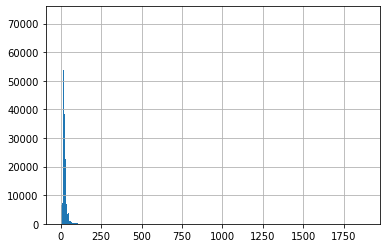

In [15]:
segments.seg_length.hist(bins=500)

Though most of the transits appear to be short, there are a few longer distances that make the plot difficult to read. This is where a transformation is useful:

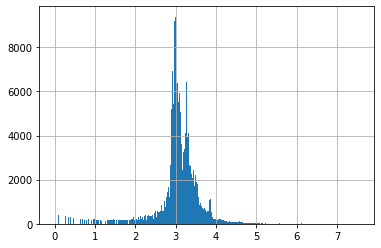

In [16]:
segments.seg_length.apply(np.log).hist(bins=500)

We can see that although there are date/time fields in the dataset, they are not in any specialized format, such as `datetime`.

In [17]:
segments.st_time.dtype

dtype('O')

Our first order of business will be to convert these data to `datetime`. The `strptime` method parses a string representation of a date and/or time field, according to the expected format of this information.

In [18]:
datetime.strptime(segments.st_time.ix[0], '%m/%d/%y %H:%M')

/home/logician724/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


datetime.datetime(2009, 2, 10, 16, 3)

The `dateutil` package includes a parser that attempts to detect the format of the date strings, and convert them automatically.

In [19]:
from dateutil.parser import parse

In [20]:
parse(segments.st_time.ix[0])

/home/logician724/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


datetime.datetime(2009, 2, 10, 16, 3)

We can convert all the dates in a particular column by using the `apply` method.

In [21]:
segments.st_time.apply(lambda d: datetime.strptime(d, '%m/%d/%y %H:%M'))

0        2009-02-10 16:03:00
1        2009-04-06 14:31:00
2        2009-04-06 14:36:00
3        2009-04-10 17:58:00
4        2009-04-10 17:59:00
                 ...        
262521   2010-06-15 12:49:00
262522   2010-06-15 21:32:00
262523   2010-06-17 19:16:00
262524   2010-06-18 02:52:00
262525   2010-06-18 10:19:00
Name: st_time, Length: 262526, dtype: datetime64[ns]

As a convenience, Pandas has a `to_datetime` method that will parse and convert an entire Series of formatted strings into `datetime` objects.

In [22]:
pd.to_datetime(segments.st_time)

0        2009-02-10 16:03:00
1        2009-04-06 14:31:00
2        2009-04-06 14:36:00
3        2009-04-10 17:58:00
4        2009-04-10 17:59:00
                 ...        
262521   2010-06-15 12:49:00
262522   2010-06-15 21:32:00
262523   2010-06-17 19:16:00
262524   2010-06-18 02:52:00
262525   2010-06-18 10:19:00
Name: st_time, Length: 262526, dtype: datetime64[ns]

Pandas also has a custom NA value for missing datetime objects, `NaT`.

In [23]:
pd.to_datetime([None])

DatetimeIndex(['NaT'], dtype='datetime64[ns]', freq=None)

Also, if `to_datetime()` has problems parsing any particular date/time format, you can pass the spec in using the `format=` argument.

## Merging and joining DataFrame objects

Now that we have the vessel transit information as we need it, we may want a little more information regarding the vessels themselves. In the `data/AIS` folder there is a second table that contains information about each of the ships that traveled the segments in the `segments` table.

In [24]:
vessels = pd.read_csv("data/AIS/vessel_information.csv", index_col='mmsi')
vessels.head()

      num_names                                              names sov  \
mmsi                                                                     
1             8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y   
9             3                         000000009/Raven/Shearwater   N   
21            1                                      Us Gov Vessel   Y   
74            2                                  Mcfaul/Sarah Bell   N   
103           3           Ron G/Us Navy Warship 103/Us Warship 103   Y   

         flag flag_type  num_loas                                    loa  \
mmsi                                                                       
1     Unknown   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0   
9     Unknown   Unknown         2                              50.0/62.0   
21    Unknown   Unknown         1                                  208.0   
74    Unknown   Unknown         1                                  155.0   
103   Unknown   Unknown  

In [22]:
[v for v in vessels.type.unique() if v.find('/')==-1]

['Unknown',
 'Other',
 'Tug',
 'Towing',
 'Pleasure',
 'Cargo',
 'WIG',
 'Fishing',
 'BigTow',
 'MilOps',
 'Tanker',
 'Passenger',
 'SAR',
 'Sailing',
 'Reserved',
 'Law',
 'Dredging',
 'AntiPol',
 'Pilot',
 'HSC',
 'Diving',
 'Resol-18',
 'Tender',
 'Spare',
 'Medical']

In [23]:
vessels.type.value_counts()

Cargo        5622
Tanker       2440
Pleasure      601
Tug           221
Sailing       205
Fishing       200
Other         178
Passenger     150
Towing        117
Unknown       106
...
BigTow/Tanker/Towing/Tug          1
Fishing/SAR/Unknown               1
BigTow/Reserved/Towing/Tug/WIG    1
Reserved/Tanker/Towing/Tug        1
Cargo/Reserved/Unknown            1
Reserved/Towing/Tug               1
BigTow/Unknown                    1
Fishing/Law                       1
BigTow/Towing/WIG                 1
Towing/Unknown/WIG                1
AntiPol/Fishing/Pleasure          1
Length: 206, dtype: int64

The challenge, however, is that several ships have travelled multiple segments, so there is not a one-to-one relationship between the rows of the two tables. The table of vessel information has a *one-to-many* relationship with the segments.

In Pandas, we can combine tables according to the value of one or more *keys* that are used to identify rows, much like an index. Using a trivial example:

In [24]:
df1 = pd.DataFrame(dict(id=range(4), age=np.random.randint(18, 31, size=4)))
df2 = pd.DataFrame(dict(id=range(3)+range(3), score=np.random.random(size=6)))

df1, df2

(   age  id
 0   24   0
 1   25   1
 2   25   2
 3   30   3,    id     score
 0   0  0.068840
 1   1  0.784715
 2   2  0.590726
 3   0  0.892117
 4   1  0.506912
 5   2  0.721110)

In [25]:
pd.merge(df1, df2)

   age  id     score
0   24   0  0.068840
1   24   0  0.892117
2   25   1  0.784715
3   25   1  0.506912
4   25   2  0.590726
5   25   2  0.721110

Notice that without any information about which column to use as a key, Pandas did the right thing and used the `id` column in both tables. Unless specified otherwise, `merge` will used any common column names as keys for merging the tables. 

Notice also that `id=3` from `df1` was omitted from the merged table. This is because, by default, `merge` performs an **inner join** on the tables, meaning that the merged table represents an intersection of the two tables.

In [26]:
pd.merge(df1, df2, how='outer')

   age  id     score
0   24   0  0.068840
1   24   0  0.892117
2   25   1  0.784715
3   25   1  0.506912
4   25   2  0.590726
5   25   2  0.721110
6   30   3       NaN

The **outer join** above yields the union of the two tables, so all rows are represented, with missing values inserted as appropriate. One can also perform **right** and **left** joins to include all rows of the right or left table (*i.e.* first or second argument to `merge`), but not necessarily the other.

Looking at the two datasets that we wish to merge:

In [27]:
segments.head(1)

   mmsi         name  transit  segment  seg_length  avg_sog  min_sog  max_sog  \
0     1  Us Govt Ves        1        1         5.1     13.2      9.2     14.5   

   pdgt10        st_time       end_time  
0    96.5  2/10/09 16:03  2/10/09 16:27  

In [28]:
vessels.head(1)

      num_names                                              names sov  \
mmsi                                                                     
1             8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y   

         flag flag_type  num_loas                                    loa  \
mmsi                                                                       
1     Unknown   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0   

      max_loa  num_types                             type  
mmsi                                                       
1         156          4  Dredging/MilOps/Reserved/Towing  

we see that there is a `mmsi` value (a vessel identifier) in each table, but it is used as an index for the `vessels` table. In this case, we have to specify to join on the index for this table, and on the `mmsi` column for the other.

In [29]:
segments_merged = pd.merge(vessels, segments, left_index=True, right_on='mmsi')

In [30]:
segments_merged.head()

   num_names                                              names sov     flag  \
0          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
1          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
2          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
3          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
4          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   

  flag_type  num_loas                                    loa  max_loa  \
0   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
1   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
2   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
3   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
4   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   

   num_types                             type  \
0          4  Dredging/MilOps/R

In this case, the default inner join is suitable; we are not interested in observations from either table that do not have corresponding entries in the other. 

Notice that `mmsi` field that was an index on the `vessels` table is no longer an index on the merged table.

Here, we used the `merge` function to perform the merge; we could also have used the `merge` method for either of the tables:

In [31]:
vessels.merge(segments, left_index=True, right_on='mmsi').head()

   num_names                                              names sov     flag  \
0          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
1          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
2          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
3          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
4          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   

  flag_type  num_loas                                    loa  max_loa  \
0   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
1   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
2   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
3   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
4   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   

   num_types                             type  \
0          4  Dredging/MilOps/R

Occasionally, there will be fields with the same in both tables that we do not wish to use to join the tables; they may contain different information, despite having the same name. In this case, Pandas will by default append suffixes `_x` and `_y` to the columns to uniquely identify them.

In [32]:
segments['type'] = 'foo'
pd.merge(vessels, segments, left_index=True, right_on='mmsi').head()

   num_names                                              names sov     flag  \
0          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
1          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
2          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
3          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   
4          8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y  Unknown   

  flag_type  num_loas                                    loa  max_loa  \
0   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
1   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
2   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
3   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   
4   Unknown         7  42.0/48.0/57.0/90.0/138.0/154.0/156.0      156   

   num_types                           type_x  \
0          4  Dredging/MilOps/R

This behavior can be overridden by specifying a `suffixes` argument, containing a list of the suffixes to be used for the columns of the left and right columns, respectively.

## Concatenation

A common data manipulation is appending rows or columns to a dataset that already conform to the dimensions of the exsiting rows or colums, respectively. In NumPy, this is done either with `concatenate` or the convenience functions `c_` and `r_`:

In [33]:
np.concatenate([np.random.random(5), np.random.random(5)])

array([ 0.95922038,  0.39563796,  0.13163705,  0.94429727,  0.01549658,
        0.12911028,  0.75731272,  0.01583536,  0.56940704,  0.34045001])

In [34]:
np.r_[np.random.random(5), np.random.random(5)]

array([ 0.80586099,  0.34971419,  0.39173205,  0.61992008,  0.64169057,
        0.31249921,  0.97907553,  0.18102001,  0.67703841,  0.25629399])

In [35]:
np.c_[np.random.random(5), np.random.random(5)]

array([[ 0.40759603,  0.66875812],
       [ 0.75010699,  0.64254533],
       [ 0.19492038,  0.04028105],
       [ 0.139481  ,  0.96799951],
       [ 0.81245418,  0.83274143]])

This operation is also called *binding* or *stacking*.

With Pandas' indexed data structures, there are additional considerations as the overlap in index values between two data structures affects how they are concatenate.

Lets import two microbiome datasets, each consisting of counts of microorganiams from a particular patient. We will use the first column of each dataset as the index.

In [36]:
mb1 = pd.read_excel('data/microbiome/MID1.xls', 'Sheet 1', index_col=0, header=None)
mb2 = pd.read_excel('data/microbiome/MID2.xls', 'Sheet 1', index_col=0, header=None)
mb1.shape, mb2.shape

((272, 1), (288, 1))

In [37]:
mb1.head()

                                                                                         1
0                                                                                         
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera    7
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus          2
Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus              3
Archaea "Crenarchaeota" Thermoprotei Thermoproteales Thermofilaceae Thermofilum          3
Archaea "Euryarchaeota" "Methanomicrobia" Methanocellales Methanocellaceae Methanocella  7

Let's give the index and columns meaningful labels:

In [38]:
mb1.columns = mb2.columns = ['Count']

In [39]:
mb1.index.name = mb2.index.name = 'Taxon'

In [40]:
mb1.head()

                                                                                         Count
Taxon                                                                                         
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera        7
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus              2
Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus                  3
Archaea "Crenarchaeota" Thermoprotei Thermoproteales Thermofilaceae Thermofilum              3
Archaea "Euryarchaeota" "Methanomicrobia" Methanocellales Methanocellaceae Methanocella      7

The index of these data is the unique biological classification of each organism, beginning with *domain*, *phylum*, *class*, and for some organisms, going all the way down to the genus level.

![classification](http://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Biological_classification_L_Pengo_vflip.svg/150px-Biological_classification_L_Pengo_vflip.svg.png)

In [41]:
mb1.index[:3]

Index([u'Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera', u'Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus', u'Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus'], dtype='object')

In [42]:
mb1.index.is_unique

True

If we concatenate along `axis=0` (the default), we will obtain another data frame with the the rows concatenated:

In [43]:
pd.concat([mb1, mb2], axis=0).shape

(560, 1)

However, the index is no longer unique, due to overlap between the two DataFrames.

In [44]:
pd.concat([mb1, mb2], axis=0).index.is_unique

False

Concatenating along `axis=1` will concatenate column-wise, but respecting the indices of the two DataFrames.

In [45]:
pd.concat([mb1, mb2], axis=1).shape

(438, 2)

In [46]:
pd.concat([mb1, mb2], axis=1).head()

                                                                                            Count  \
Archaea "Crenarchaeota" Thermoprotei Acidilobales Acidilobaceae Acidilobus                    NaN   
Archaea "Crenarchaeota" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera               NaN   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera           7   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus    NaN   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera       NaN   

                                                                                            Count  
Archaea "Crenarchaeota" Thermoprotei Acidilobales Acidilobaceae Acidilobus                      2  
Archaea "Crenarchaeota" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera                14  
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera        

In [47]:
pd.concat([mb1, mb2], axis=1).values[:5]

array([[ nan,   2.],
       [ nan,  14.],
       [  7.,  23.],
       [ nan,   1.],
       [ nan,   2.]])

If we are only interested in taxa that are included in both DataFrames, we can specify a `join=inner` argument.

In [48]:
pd.concat([mb1, mb2], axis=1, join='inner').head()

                                                                                         Count  \
Taxon                                                                                            
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera        7   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus              2   
Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus                  3   
Archaea "Crenarchaeota" Thermoprotei Thermoproteales Thermofilaceae Thermofilum              3   
Archaea "Euryarchaeota" "Methanomicrobia" Methanocellales Methanocellaceae Methanocella      7   

                                                                                         Count  
Taxon                                                                                           
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera       23  
Archaea "Crenarchaeota

If we wanted to use the second table to fill values absent from the first table, we could use `combine_first`.

In [49]:
mb1.combine_first(mb2).head()

                                                                                            Count
Taxon                                                                                            
Archaea "Crenarchaeota" Thermoprotei Acidilobales Acidilobaceae Acidilobus                      2
Archaea "Crenarchaeota" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera                14
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera           7
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus      1
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera         2

We can also create a hierarchical index based on keys identifying the original tables.

In [50]:
pd.concat([mb1, mb2], keys=['patient1', 'patient2']).head()

                                                                                                  Count
         Taxon                                                                                         
patient1 Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera        7
         Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus              2
         Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus                  3
         Archaea "Crenarchaeota" Thermoprotei Thermoproteales Thermofilaceae Thermofilum              3
         Archaea "Euryarchaeota" "Methanomicrobia" Methanocellales Methanocellaceae Methanocella      7

In [51]:
pd.concat([mb1, mb2], keys=['patient1', 'patient2']).index.is_unique

True

Alternatively, you can pass keys to the concatenation by supplying the DataFrames (or Series) as a dict.

In [52]:
pd.concat(dict(patient1=mb1, patient2=mb2), axis=1).head()

                                                                                            patient1  \
                                                                                               Count   
Archaea "Crenarchaeota" Thermoprotei Acidilobales Acidilobaceae Acidilobus                       NaN   
Archaea "Crenarchaeota" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera                  NaN   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera              7   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus       NaN   
Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera          NaN   

                                                                                            patient2  
                                                                                               Count  
Archaea "Crenarchaeota" Thermoprotei Acidilobales Acidilobaceae A

If you want `concat` to work like `numpy.concatanate`, you may provide the `ignore_index=True` argument.

## Exercise

In the *data/microbiome* subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10th file that describes the content of each. Write code that imports each of the data spreadsheets and combines them into a single `DataFrame`, adding the identifying information from the metadata spreadsheet as columns in the combined `DataFrame`.

In [52]:
# Write your answer here

## Reshaping DataFrame objects

In the context of a single DataFrame, we are often interested in re-arranging the layout of our data. 

This dataset in from Table 6.9 of [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

* Randomized to placebo (N=36), 5000 units of BotB (N=36), 10,000 units of BotB (N=37)
* Response variable: total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment)
* TWSTRS measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began

In [53]:
cdystonia = pd.read_csv("data/cdystonia.csv", index_col=None)
cdystonia.head()

   patient  obs  week  site  id  treat  age sex  twstrs
0        1    1     0     1   1  5000U   65   F      32
1        1    2     2     1   1  5000U   65   F      30
2        1    3     4     1   1  5000U   65   F      24
3        1    4     8     1   1  5000U   65   F      37
4        1    5    12     1   1  5000U   65   F      39

This dataset includes repeated measurements of the same individuals (longitudinal data). Its possible to present such information in (at least) two ways: showing each repeated measurement in their own row, or in multiple columns representing mutliple measurements.


The `stack` method rotates the data frame so that columns are represented in rows:

In [54]:
stacked = cdystonia.stack()
stacked

0  patient        1
   obs            1
   week           0
   site           1
   id             1
   treat      5000U
   age           65
   sex            F
   twstrs        32
1  patient        1
...
629  sex            M
     twstrs        36
630  patient      109
     obs            6
     week          16
     site           9
     id            11
     treat      5000U
     age           57
     sex            M
     twstrs        51
Length: 5679, dtype: object

To complement this, `unstack` pivots from rows back to columns.

In [55]:
stacked.unstack().head()

  patient obs week site id  treat age sex twstrs
0       1   1    0    1  1  5000U  65   F     32
1       1   2    2    1  1  5000U  65   F     30
2       1   3    4    1  1  5000U  65   F     24
3       1   4    8    1  1  5000U  65   F     37
4       1   5   12    1  1  5000U  65   F     39

For this dataset, it makes sense to create a hierarchical index based on the patient and observation:

In [56]:
cdystonia2 = cdystonia.set_index(['patient','obs'])
cdystonia2.head()

             week  site  id  treat  age sex  twstrs
patient obs                                        
1       1       0     1   1  5000U   65   F      32
        2       2     1   1  5000U   65   F      30
        3       4     1   1  5000U   65   F      24
        4       8     1   1  5000U   65   F      37
        5      12     1   1  5000U   65   F      39

In [57]:
cdystonia2.index.is_unique

True

If we want to transform this data so that repeated measurements are in columns, we can `unstack` the `twstrs` measurements according to `obs`.

In [58]:
twstrs_wide = cdystonia2['twstrs'].unstack('obs')
twstrs_wide.head()

obs       1   2   3   4   5   6
patient                        
1        32  30  24  37  39  36
2        60  26  27  41  65  67
3        44  20  23  26  35  35
4        53  61  64  62 NaN NaN
5        53  35  48  49  41  51

In [59]:
cdystonia_long = cdystonia[['patient','site','id','treat','age','sex']].drop_duplicates().merge(
                    twstrs_wide, right_index=True, left_on='patient', how='inner').head()
cdystonia_long

    patient  site  id    treat  age sex   1   2   3   4   5   6
0         1     1   1    5000U   65   F  32  30  24  37  39  36
6         2     1   2   10000U   70   F  60  26  27  41  65  67
12        3     1   3    5000U   64   F  44  20  23  26  35  35
18        4     1   4  Placebo   59   F  53  61  64  62 NaN NaN
22        5     1   5   10000U   76   F  53  35  48  49  41  51

A slightly cleaner way of doing this is to set the patient-level information as an index before unstacking:

In [60]:
cdystonia.set_index(['patient','site','id','treat','age','sex','week'])['twstrs'].unstack('week').head()

week                             0   2   4   8   12  16
patient site id treat   age sex                        
1       1    1  5000U   65  F    32  30  24  37  39  36
2       1    2  10000U  70  F    60  26  27  41  65  67
3       1    3  5000U   64  F    44  20  23  26  35  35
4       1    4  Placebo 59  F    53  61  64  62 NaN NaN
5       1    5  10000U  76  F    53  35  48  49  41  51

To convert our "wide" format back to long, we can use the `melt` function, appropriately parameterized:

In [61]:
pd.melt(cdystonia_long, id_vars=['patient','site','id','treat','age','sex'], 
        var_name='obs', value_name='twsters').head()

   patient  site  id    treat  age sex obs  twsters
0        1     1   1    5000U   65   F   1       32
1        2     1   2   10000U   70   F   1       60
2        3     1   3    5000U   64   F   1       44
3        4     1   4  Placebo   59   F   1       53
4        5     1   5   10000U   76   F   1       53

This illustrates the two formats for longitudinal data: **long** and **wide** formats. Its typically better to store data in long format because additional data can be included as additional rows in the database, while wide format requires that the entire database schema be altered by adding columns to every row as data are collected.

The preferable format for analysis depends entirely on what is planned for the data, so it is imporant to be able to move easily between them.

## Pivoting

The `pivot` method allows a DataFrame to be transformed easily between long and wide formats in the same way as a pivot table is created in a spreadsheet. It takes three arguments: `index`, `columns` and `values`, corresponding to the DataFrame index (the row headers), columns and cell values, respectively.

For example, we may want the `twstrs` variable (the response variable) in wide format according to patient:

In [62]:
cdystonia.pivot(index='patient', columns='obs', values='twstrs').head()

obs       1   2   3   4   5   6
patient                        
1        32  30  24  37  39  36
2        60  26  27  41  65  67
3        44  20  23  26  35  35
4        53  61  64  62 NaN NaN
5        53  35  48  49  41  51

If we omit the `values` argument, we get a `DataFrame` with hierarchical columns, just as when we applied `unstack` to the hierarchically-indexed table:

In [63]:
cdystonia.pivot('patient', 'obs')

         week                      site             ...  sex                 \
obs         1   2   3   4   5   6     1   2   3   4 ...    3    4    5    6   
patient                                             ...                       
1           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
2           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
3           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
4           0   2   4   8 NaN NaN     1   1   1   1 ...    F    F  NaN  NaN   
5           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
6           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
7           0   2   4   8  12  16     1   1   1   1 ...    M    M    M    M   
8           0   2   4   8  12  16     1   1   1   1 ...    M    M    M    M   
9           0   2   4   8  12  16     1   1   1   1 ...    F    F    F    F   
10          0   2   4   8  12  16     1   1   1   1 

A related method, `pivot_table`, creates a spreadsheet-like table with a hierarchical index, and allows the values of the table to be populated using an arbitrary aggregation function.

In [64]:
cdystonia.pivot_table(rows=['site', 'treat'], cols='week', values='twstrs', aggfunc=max).head(20)

/usr/local/lib/python2.7/site-packages/pandas/util/decorators.py:53: FutureWarning: cols is deprecated, use columns instead
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python2.7/site-packages/pandas/util/decorators.py:53: FutureWarning: rows is deprecated, use index instead
  warnings.warn(msg, FutureWarning)


week          0   2   4   8   12  16
site treat                          
1    10000U   60  41  48  49  65  67
     5000U    44  32  34  43  42  46
     Placebo  53  61  64  62  32  38
2    10000U   65  60  60  64  67  66
     5000U    67  64  65  64  62  64
     Placebo  53  56  52  57  61  54
3    10000U   50  43  51  46  49  56
     5000U    52  44  47  50  50  49
     Placebo  43  38  40  48  49  44
4    10000U   54  52  52  54  51  57
     5000U    52  34  43  45  47  46
     Placebo  52  55  51  52  54  57
5    10000U   50  50  32  46  54  57
     5000U    60  53  55  62  67  26
     Placebo  60  57  53  52  53  58
6    10000U   55  56  47  53  51  51
     5000U    59  55  50  56  59  53
     Placebo  54  53  51  57  57  57
7    10000U   53  47  45  45  50  53
     5000U    53  45  52  51  52  53

For a simple cross-tabulation of group frequencies, the `crosstab` function (not a method) aggregates counts of data according to factors in rows and columns. The factors may be hierarchical if desired.

In [65]:
pd.crosstab(cdystonia.sex, cdystonia.site)

site   1   2   3   4   5   6   7   8   9
sex                                     
F     52  53  42  30  22  54  66  48  28
M     18  29  30  18  11  33   6  58  33

## Data transformation

There are a slew of additional operations for DataFrames that we would collectively refer to as "transformations" that include tasks such as removing duplicate values, replacing values, and grouping values.

### Dealing with duplicates

We can easily identify and remove duplicate values from `DataFrame` objects. For example, say we want to removed ships from our `vessels` dataset that have the same name:

In [66]:
vessels.duplicated(cols='names')

/usr/local/lib/python2.7/site-packages/pandas/util/decorators.py:53: FutureWarning: cols is deprecated, use subset instead
  warnings.warn(msg, FutureWarning)


mmsi
1        False
9        False
21       False
74       False
103      False
310      False
3011     False
4731     False
15151    False
46809    False
...
812719000    False
857632392    False
866946820     True
888888882     True
888888888    False
900000000    False
919191919    False
967191190     True
975318642     True
987654321    False
999999999     True
Length: 10771, dtype: bool

In [67]:
vessels.drop_duplicates(['names'])

           num_names                                              names sov  \
mmsi                                                                          
1                  8  Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   Y   
9                  3                         000000009/Raven/Shearwater   N   
21                 1                                      Us Gov Vessel   Y   
74                 2                                  Mcfaul/Sarah Bell   N   
103                3           Ron G/Us Navy Warship 103/Us Warship 103   Y   
310                1                                           Arabella   N   
3011               1                                         Charleston   N   
4731               1                                          000004731   N   
15151              2                             R L Enterkin/Us Vessel   N   
46809              1                                      Island Trader   N   
80404              1                                

### Value replacement

Frequently, we get data columns that are encoded as strings that we wish to represent numerically for the purposes of including it in a quantitative analysis. For example, consider the treatment variable in the cervical dystonia dataset:

In [68]:
cdystonia.treat.value_counts()

10000U     213
5000U      211
Placebo    207
dtype: int64

A logical way to specify these numerically is to change them to integer values, perhaps using "Placebo" as a baseline value. If we create a dict with the original values as keys and the replacements as values, we can pass it to the `map` method to implement the changes.

In [69]:
treatment_map = {'Placebo': 0, '5000U': 1, '10000U': 2}

In [70]:
cdystonia['treatment'] = cdystonia.treat.map(treatment_map)
cdystonia.treatment

0    1
1    1
2    1
3    1
4    1
5    1
6    2
7    2
8    2
9    2
...
620    2
621    2
622    2
623    2
624    2
625    2
626    1
627    1
628    1
629    1
630    1
Name: treatment, Length: 631, dtype: int64

Alternately, if we simply want to replace particular values in a `Series` or `DataFrame`, we can use the `replace` method. 

An example where replacement is useful is dealing with zeros in certain transformations. For example, if we try to take the log of a set of values:

In [71]:
vals = pd.Series([float(i)**10 for i in range(10)])
vals

0             0
1             1
2          1024
3         59049
4       1048576
5       9765625
6      60466176
7     282475249
8    1073741824
9    3486784401
dtype: float64

In [72]:
np.log(vals)

0         -inf
1     0.000000
2     6.931472
3    10.986123
4    13.862944
5    16.094379
6    17.917595
7    19.459101
8    20.794415
9    21.972246
dtype: float64

In such situations, we can replace the zero with a value so small that it makes no difference to the ensuing analysis. We can do this with `replace`.

In [73]:
vals = vals.replace(0, 1e-6)
np.log(vals)

0   -13.815511
1     0.000000
2     6.931472
3    10.986123
4    13.862944
5    16.094379
6    17.917595
7    19.459101
8    20.794415
9    21.972246
dtype: float64

We can also perform the same replacement that we used `map` for with `replace`:

In [74]:
cdystonia2.treat.replace({'Placebo': 0, '5000U': 1, '10000U': 2})

patient  obs
1        1      1
         2      1
         3      1
         4      1
         5      1
         6      1
2        1      2
         2      2
         3      2
         4      2
...
108      1      2
         2      2
         3      2
         4      2
         5      2
         6      2
109      1      1
         2      1
         4      1
         5      1
         6      1
Name: treat, Length: 631, dtype: int64

### Inidcator variables

For some statistical analyses (*e.g.* regression models or analyses of variance), categorical or group variables need to be converted into columns of indicators--zeros and ones--to create a so-called **design matrix**. The Pandas function `get_dummies` (indicator variables are also known as *dummy variables*) makes this transformation straightforward.

Let's consider the DataFrame containing the ships corresponding to the transit segments on the eastern seaboard. The `type` variable denotes the class of vessel; we can create a matrix of indicators for this. For simplicity, lets filter out the 5 most common types of ships:


In [75]:
top5 = vessels.type.apply(lambda s: s in vessels.type.value_counts().index[:5])
vessels5 = vessels[top5]

In [76]:
pd.get_dummies(vessels5.type).head(10)

         Cargo  Pleasure  Sailing  Tanker  Tug
mmsi                                          
15151        0         0        0       0    1
80404        0         1        0       0    0
366235       1         0        0       0    0
587370       0         0        0       0    1
693559       0         0        0       0    1
1233916      0         1        0       0    0
3041300      1         0        0       0    0
3663760      1         0        0       0    0
3688360      1         0        0       0    0
7718175      1         0        0       0    0

### Discretization

Pandas' `cut` function can be used to group continuous or countable data in to bins. Discretization is generally a very **bad idea** for statistical analysis, so use this function responsibly!

Lets say we want to bin the ages of the cervical dystonia patients into a smaller number of groups:

In [77]:
cdystonia.age.describe()

count    631.000000
mean      55.616482
std       12.123910
min       26.000000
25%       46.000000
50%       56.000000
75%       65.000000
max       83.000000
dtype: float64

Let's transform these data into decades, beginnnig with individuals in their 20's and ending with those in their 90's:

In [78]:
pd.cut(cdystonia.age, [20,30,40,50,60,70,80,90])[:30]

 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
 (60, 70]
...
 (50, 60]
 (50, 60]
 (50, 60]
 (70, 80]
 (70, 80]
 (70, 80]
 (70, 80]
 (70, 80]
 (70, 80]
 (50, 60]
 (50, 60]
Levels (7): Index(['(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]',
                   '(60, 70]', '(70, 80]', '(80, 90]'], dtype=object)
Length: 30

The parentheses indicate an open interval, meaning that the interval includes values up to but *not including* the endpoint, whereas the square bracket is a closed interval, where the endpoint is included in the interval. We can switch the closure to the left side by setting the `right` flag to `False`:

In [79]:
pd.cut(cdystonia.age, [20,30,40,50,60,70,80,90], right=False)[:30]

 [60, 70)
 [60, 70)
 [60, 70)
 [60, 70)
 [60, 70)
 [60, 70)
 [70, 80)
 [70, 80)
 [70, 80)
 [70, 80)
...
 [50, 60)
 [50, 60)
 [50, 60)
 [70, 80)
 [70, 80)
 [70, 80)
 [70, 80)
 [70, 80)
 [70, 80)
 [50, 60)
 [50, 60)
Levels (7): Index(['[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)',
                   '[60, 70)', '[70, 80)', '[80, 90)'], dtype=object)
Length: 30

Since the data are now **ordinal**, rather than numeric, we can give them labels:

In [80]:
pd.cut(cdystonia.age, [20,40,60,80,90], labels=['young','middle-aged','old','ancient'])[:30]

 old
 old
 old
 old
 old
 old
 old
 old
 old
 old
...
 middle-aged
 middle-aged
 middle-aged
         old
         old
         old
         old
         old
         old
 middle-aged
 middle-aged
Levels (4): Index(['young', 'middle-aged', 'old', 'ancient'], dtype=object)
Length: 30

A related function `qcut` uses empirical quantiles to divide the data. If, for example, we want the quartiles -- (0-25%], (25-50%], (50-70%], (75-100%] -- we can just specify 4 intervals, which will be equally-spaced by default:

In [81]:
pd.qcut(cdystonia.age, 4)[:30]

 (56, 65]
 (56, 65]
 (56, 65]
 (56, 65]
 (56, 65]
 (56, 65]
 (65, 83]
 (65, 83]
 (65, 83]
 (65, 83]
...
 (56, 65]
 (56, 65]
 (56, 65]
 (65, 83]
 (65, 83]
 (65, 83]
 (65, 83]
 (65, 83]
 (65, 83]
 (56, 65]
 (56, 65]
Levels (4): Index(['[26, 46]', '(46, 56]', '(56, 65]', '(65, 83]'], dtype=object)
Length: 30

Alternatively, one can specify custom quantiles to act as cut points:

In [82]:
quantiles = pd.qcut(segments.seg_length, [0, 0.01, 0.05, 0.95, 0.99, 1])
quantiles[:30]

   (1.8, 7.8]
  (7.8, 45.4]
   (1.8, 7.8]
  (7.8, 45.4]
  (7.8, 45.4]
  (7.8, 45.4]
 (45.4, 89.7]
  (7.8, 45.4]
  (7.8, 45.4]
  (7.8, 45.4]
...
 (7.8, 45.4]
  (1.8, 7.8]
  (1.8, 7.8]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
 (7.8, 45.4]
Levels (5): Index(['[1, 1.8]', '(1.8, 7.8]', '(7.8, 45.4]',
                   '(45.4, 89.7]', '(89.7, 1882]'], dtype=object)
Length: 30

Note that you can easily combine discretiztion with the generation of indicator variables shown above:

In [83]:
pd.get_dummies(quantiles).head(10)

   (1.8, 7.8]  (45.4, 89.7]  (7.8, 45.4]  (89.7, 1882]  [1, 1.8]
0           1             0            0             0         0
1           0             0            1             0         0
2           1             0            0             0         0
3           0             0            1             0         0
4           0             0            1             0         0
5           0             0            1             0         0
6           0             1            0             0         0
7           0             0            1             0         0
8           0             0            1             0         0
9           0             0            1             0         0

### Permutation and sampling

For some data analysis tasks, such as simulation, we need to be able to randomly reorder our data, or draw random values from it. Calling NumPy's `permutation` function with the length of the sequence you want to permute generates an array with a permuted sequence of integers, which can be used to re-order the sequence.

In [84]:
new_order = np.random.permutation(len(segments))
new_order[:30]

array([183316, 108225,  92326,  60611, 134460, 170622, 117439,  13979,
       243115,  69470,  13594, 160103,  73039, 158974, 220079,  20341,
        87882,   4430, 139083,  23082,  18110, 169543, 169578, 119516,
       227857, 123216, 252938,  52744,  88292, 208914])

Using this sequence as an argument to the `take` method results in a reordered DataFrame:

In [85]:
segments.take(new_order).head()

             mmsi           name  transit  segment  seg_length  avg_sog  \
183316  367839000    Us Epa Bold       14        1        17.9      6.0   
108225  366739960       Mckinley      135        1        26.9      8.1   
92326   354591000   Pyxis Leader       30        1        30.3     14.9   
60611   309942000     Dole Chile      178        1        18.5     19.0   
134460  366997360  Norwegian Sea      201        1        25.9      6.9   

        min_sog  max_sog  pdgt10         st_time       end_time type  
183316      5.3      7.1     0.0    7/19/09 7:00   7/19/09 9:23  foo  
108225      7.7      8.7     0.0  10/13/10 22:06  10/14/10 1:23  foo  
92326       7.2     17.2    94.4    8/3/10 22:58    8/4/10 0:59  foo  
60611      15.5     19.8   100.0     5/8/12 4:27    5/8/12 5:26  foo  
134460      6.5      7.1     0.0    4/3/12 10:40   4/3/12 14:26  foo  

Compare this ordering with the original:

In [86]:
segments.head()

   mmsi               name  transit  segment  seg_length  avg_sog  min_sog  \
0     1        Us Govt Ves        1        1         5.1     13.2      9.2   
1     1  Dredge Capt Frank        1        1        13.5     18.6     10.4   
2     1      Us Gov Vessel        1        1         4.3     16.2     10.3   
3     1      Us Gov Vessel        2        1         9.2     15.4     14.5   
4     1  Dredge Capt Frank        2        1         9.2     15.4     14.6   

   max_sog  pdgt10        st_time       end_time type  
0     14.5    96.5  2/10/09 16:03  2/10/09 16:27  foo  
1     20.6   100.0   4/6/09 14:31   4/6/09 15:20  foo  
2     20.5   100.0   4/6/09 14:36   4/6/09 14:55  foo  
3     16.1   100.0  4/10/09 17:58  4/10/09 18:34  foo  
4     16.2   100.0  4/10/09 17:59  4/10/09 18:35  foo  

## Exercise

Its easy to see how this permutation approach allows us to draw a random sample **without replacement**. How would you sample **with replacement**? Generate a random sample of 5 ships from the `vessels` DataFrame using this scheme.

In [86]:
# Write your answer here

## Data aggregation and GroupBy operations

One of the most powerful features of Pandas is its **GroupBy** functionality. On occasion we may want to perform operations on *groups* of observations within a dataset. For exmaple:

* **aggregation**, such as computing the sum of mean of each group, which involves applying a function to each group and returning the aggregated results
* **slicing** the DataFrame into groups and then doing something with the resulting slices (*e.g.* plotting)
* group-wise **transformation**, such as standardization/normalization

In [87]:
cdystonia_grouped = cdystonia.groupby(cdystonia.patient)

This *grouped* dataset is hard to visualize



In [88]:
cdystonia_grouped

However, the grouping is only an intermediate step; for example, we may want to **iterate** over each of the patient groups:

In [89]:
for patient, group in cdystonia_grouped:
    print patient
    print group
    print

1
   patient  obs  week  site  id  treat  age sex  twstrs  treatment
0        1    1     0     1   1  5000U   65   F      32          1
1        1    2     2     1   1  5000U   65   F      30          1
2        1    3     4     1   1  5000U   65   F      24          1
3        1    4     8     1   1  5000U   65   F      37          1
4        1    5    12     1   1  5000U   65   F      39          1
5        1    6    16     1   1  5000U   65   F      36          1

2
    patient  obs  week  site  id   treat  age sex  twstrs  treatment
6         2    1     0     1   2  10000U   70   F      60          2
7         2    2     2     1   2  10000U   70   F      26          2
8         2    3     4     1   2  10000U   70   F      27          2
9         2    4     8     1   2  10000U   70   F      41          2
10        2    5    12     1   2  10000U   70   F      65          2
11        2    6    16     1   2  10000U   70   F      67          2

3
    patient  obs  week  site  id  treat 

A common data analysis procedure is the **split-apply-combine** operation, which groups subsets of data together, applies a function to each of the groups, then recombines them into a new data table.

For example, we may want to aggregate our data with with some function.

![split-apply-combine](http://f.cl.ly/items/0s0Z252j0X0c3k3P1M47/Screen%20Shot%202013-06-02%20at%203.04.04%20PM.png)

<div align="right">*(figure taken from "Python for Data Analysis", p.251)*</div>

We can aggregate in Pandas using the `aggregate` (or `agg`, for short) method:

In [91]:
cdystonia_grouped.agg(np.mean).head()

         patient  obs  week  site  id  age     twstrs  treatment
patient                                                         
1              1  3.5   7.0     1   1   65  33.000000          1
2              2  3.5   7.0     1   2   70  47.666667          2
3              3  3.5   7.0     1   3   64  30.500000          1
4              4  2.5   3.5     1   4   59  60.000000          0
5              5  3.5   7.0     1   5   76  46.166667          2

Notice that the `treat` and `sex` variables are not included in the aggregation. Since it does not make sense to aggregate non-string variables, these columns are simply ignored by the method.

Some aggregation functions are so common that Pandas has a convenience method for them, such as `mean`:

In [92]:
cdystonia_grouped.mean().head()

         patient  obs  week  site  id  age     twstrs  treatment
patient                                                         
1              1  3.5   7.0     1   1   65  33.000000          1
2              2  3.5   7.0     1   2   70  47.666667          2
3              3  3.5   7.0     1   3   64  30.500000          1
4              4  2.5   3.5     1   4   59  60.000000          0
5              5  3.5   7.0     1   5   76  46.166667          2

The `add_prefix` and `add_suffix` methods can be used to give the columns of the resulting table labels that reflect the transformation:

In [93]:
cdystonia_grouped.mean().add_suffix('_mean').head()

         patient_mean  obs_mean  week_mean  site_mean  id_mean  age_mean  \
patient                                                                    
1                   1       3.5        7.0          1        1        65   
2                   2       3.5        7.0          1        2        70   
3                   3       3.5        7.0          1        3        64   
4                   4       2.5        3.5          1        4        59   
5                   5       3.5        7.0          1        5        76   

         twstrs_mean  treatment_mean  
patient                               
1          33.000000               1  
2          47.666667               2  
3          30.500000               1  
4          60.000000               0  
5          46.166667               2  

In [94]:
# The median of the `twstrs` variable
cdystonia_grouped['twstrs'].quantile(0.5)

patient
1          34.0
2          50.5
3          30.5
4          61.5
5          48.5
6          48.0
7          42.0
8          32.5
9          35.5
10         20.5
...
99         29.0
100        61.0
101        32.5
102        51.5
103        45.0
104        46.0
105        45.5
106        67.5
107        44.0
108        50.5
109        38.0
Name: twstrs, Length: 109, dtype: float64

If we wish, we can easily aggregate according to multiple keys:

In [95]:
cdystonia.groupby(['week','site']).mean().head()

           patient  obs   id        age     twstrs  treatment
week site                                                    
0    1         6.5    1  6.5  59.000000  43.083333   1.000000
     2        19.5    1  7.5  53.928571  51.857143   0.928571
     3        32.5    1  6.5  51.500000  38.750000   1.000000
     4        42.5    1  4.5  59.250000  48.125000   1.000000
     5        49.5    1  3.5  51.833333  49.333333   1.000000

Alternately, we can **transform** the data, using a function of our choice with the `transform` method:

In [96]:
normalize = lambda x: (x - x.mean())/x.std()

cdystonia_grouped.transform(normalize).head()

   patient       obs      week  site  id  age    twstrs  treatment
0      NaN -1.336306 -1.135550   NaN NaN  NaN -0.181369        NaN
1      NaN -0.801784 -0.811107   NaN NaN  NaN -0.544107        NaN
2      NaN -0.267261 -0.486664   NaN NaN  NaN -1.632322        NaN
3      NaN  0.267261  0.162221   NaN NaN  NaN  0.725476        NaN
4      NaN  0.801784  0.811107   NaN NaN  NaN  1.088214        NaN

It is easy to do column selection within `groupby` operations, if we are only interested split-apply-combine operations on a subset of columns:

In [97]:
cdystonia_grouped['twstrs'].mean().head()

patient
1          33.000000
2          47.666667
3          30.500000
4          60.000000
5          46.166667
Name: twstrs, dtype: float64

In [98]:
# This gives the same result as a DataFrame
cdystonia_grouped[['twstrs']].mean().head()

            twstrs
patient           
1        33.000000
2        47.666667
3        30.500000
4        60.000000
5        46.166667

If you simply want to divide your DataFrame into chunks for later use, its easy to convert them into a dict so that they can be easily indexed out as needed:

In [99]:
chunks = dict(list(cdystonia_grouped))

In [100]:
chunks[4]

    patient  obs  week  site  id    treat  age sex  twstrs  treatment
18        4    1     0     1   4  Placebo   59   F      53          0
19        4    2     2     1   4  Placebo   59   F      61          0
20        4    3     4     1   4  Placebo   59   F      64          0
21        4    4     8     1   4  Placebo   59   F      62          0

By default, `groupby` groups by row, but we can specify the `axis` argument to change this. For example, we can group our columns by type this way:

In [101]:
dict(list(cdystonia.groupby(cdystonia.dtypes, axis=1)))

{dtype('int64'):      patient  obs  week  site  id  age  twstrs  treatment
 0          1    1     0     1   1   65      32          1
 1          1    2     2     1   1   65      30          1
 2          1    3     4     1   1   65      24          1
 3          1    4     8     1   1   65      37          1
 4          1    5    12     1   1   65      39          1
 5          1    6    16     1   1   65      36          1
 6          2    1     0     1   2   70      60          2
 7          2    2     2     1   2   70      26          2
 8          2    3     4     1   2   70      27          2
 9          2    4     8     1   2   70      41          2
 10         2    5    12     1   2   70      65          2
 11         2    6    16     1   2   70      67          2
 ..       ...  ...   ...   ...  ..  ...     ...        ...
 619      107    6    16     9   9   50      52          2
 620      108    1     0     9  10   39      63          2
 621      108    2     2     9  10   39 

Its also possible to group by one or more levels of a hierarchical index. Recall `cdystonia2`, which we created with a hierarchical index:

In [102]:
cdystonia2.head(10)

             week  site  id   treat  age sex  twstrs
patient obs                                         
1       1       0     1   1   5000U   65   F      32
        2       2     1   1   5000U   65   F      30
        3       4     1   1   5000U   65   F      24
        4       8     1   1   5000U   65   F      37
        5      12     1   1   5000U   65   F      39
        6      16     1   1   5000U   65   F      36
2       1       0     1   2  10000U   70   F      60
        2       2     1   2  10000U   70   F      26
        3       4     1   2  10000U   70   F      27
        4       8     1   2  10000U   70   F      41

In [103]:
cdystonia2.groupby(level='obs', axis=0)['twstrs'].mean()

obs
1      45.651376
2      37.611650
3      37.066038
4      39.807692
5      42.913462
6      45.628571
Name: twstrs, dtype: float64

### Apply

We can generalize the split-apply-combine methodology by using `apply` function. This allows us to invoke any function we wish on a grouped dataset and recombine them into a DataFrame.

The function below takes a DataFrame and a column name, sorts by the column, and takes the `n` largest values of that column. We can use this with `apply` to return the largest values from every group in a DataFrame in a single call. 

In [104]:
def top(df, column, n=5):
    return df.sort_index(by=column, ascending=False)[:n]

To see this in action, consider the vessel transit segments dataset (which we merged with the vessel information to yield `segments_merged`). Say we wanted to return the 3 longest segments travelled by each ship:

In [105]:
top3segments = segments_merged.groupby('mmsi').apply(top, column='seg_length', n=3)[['names', 'seg_length']]
top3segments

                                                              names  \
mmsi                                                                  
1         6       Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   
          5       Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   
          7       Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...   
9         15                             000000009/Raven/Shearwater   
          14                             000000009/Raven/Shearwater   
          13                             000000009/Raven/Shearwater   
21        16                                          Us Gov Vessel   
          25                                          Us Gov Vessel   
          30                                          Us Gov Vessel   
74        35                                      Mcfaul/Sarah Bell   
          34                                      Mcfaul/Sarah Bell   
103       37               Ron G/Us Navy Warship 103/Us Warship 103   
...   

Notice that additional arguments for the applied function can be passed via `apply` after the function name. It assumes that the DataFrame is the first argument.

In [106]:
top3segments.head(20)

                                                     names  seg_length
mmsi                                                                  
1    6   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        76.0
     5   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        17.4
     7   Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...        13.7
9    15                         000000009/Raven/Shearwater        47.2
     14                         000000009/Raven/Shearwater        31.4
     13                         000000009/Raven/Shearwater        19.3
21   16                                      Us Gov Vessel        48.7
     25                                      Us Gov Vessel        25.3
     30                                      Us Gov Vessel        21.7
74   35                                  Mcfaul/Sarah Bell         7.4
     34                                  Mcfaul/Sarah Bell         1.4
103  37           Ron G/Us Navy Warship 103/Us Warship 103        87.5
     4

Recall the microbiome data sets that we used previously for the concatenation example. Suppose that we wish to aggregate the data at a higher biological classification than genus. For example, we can identify samples down to *class*, which is the 3rd level of organization in each index.

In [107]:
mb1.index[:3]

Index([u'Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera', u'Archaea "Crenarchaeota" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus', u'Archaea "Crenarchaeota" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus'], dtype='object')

Using the string methods `split` and `join` we can create an index that just uses the first three classifications: domain, phylum and class.

In [108]:
class_index = mb1.index.map(lambda x: ' '.join(x.split(' ')[:3]))

In [109]:
mb_class = mb1.copy()
mb_class.index = class_index

However, since there are multiple taxonomic units with the same class, our index is no longer unique:

In [110]:
mb_class.head()

                                           Count
Archaea "Crenarchaeota" Thermoprotei           7
Archaea "Crenarchaeota" Thermoprotei           2
Archaea "Crenarchaeota" Thermoprotei           3
Archaea "Crenarchaeota" Thermoprotei           3
Archaea "Euryarchaeota" "Methanomicrobia"      7

We can re-establish a unique index by summing all rows with the same class, using `groupby`:

In [111]:
mb_class.groupby(level=0).sum().head(10)

                                           Count
Archaea "Crenarchaeota" Thermoprotei          15
Archaea "Euryarchaeota" "Methanomicrobia"      9
Archaea "Euryarchaeota" Archaeoglobi           2
Archaea "Euryarchaeota" Halobacteria          12
Archaea "Euryarchaeota" Methanococci           1
Archaea "Euryarchaeota" Methanopyri           12
Archaea "Euryarchaeota" Thermoplasmata         2
Bacteria "Actinobacteria" Actinobacteria    1740
Bacteria "Aquificae" Aquificae                11
Bacteria "Bacteroidetes" "Bacteroidia"         1

### Exercise

Load the dataset in `titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [112]:
from IPython.core.display import HTML
HTML(filename='data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


Women and children first?

1. Use the `groupby` method to calculate the proportion of passengers that survived by sex.
2. Calculate the same proportion, but by class and sex.
3. Create age categories: children (under 14 years), adolescents (14-20), adult (21-64), and senior(65+), and calculate survival proportions by age category, class and sex.

In [112]:
# Write your answer here